# Undergraduate Retention Ensemble Method Pipeline

This notebook will try to improve upon the results of Lehr et al. for educational data mining of undergraduate retention. The original paper used traditional data mining techniques such as logistic regression, decision tree, and naive bayes to build a predictive model to determine what were the most important factors causing a student to drop out of college. This notebook will employ ensemble learning methods to predict the target variable "RATE" in the full dataset provided by Dr. Hong Liu.

In [1]:
import copy
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from math import floor, ceil

# imports for piplelines
from sklearn.pipeline import Pipeline, FeatureUnion

# built-in transformer which we will use in our pipelines
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder

#evaluation metrics  
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve

# models and model selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

# custom imports
from custom_transformers import DataFrameSelector, ZeroVariance, FindCorrelation
from custom_transformers import OptionalStandardScaler, ManualDropper, PipelineChecker
from ml_plot import kde_plot, hist_plot, cat_plot, pairwise_plot, LiftChart, ROCPlot, train_plot

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Preprocessing data

We will be working with the "data full.csv" dataset.

In [2]:
#Allows you to see all columns
pd.set_option('display.max_columns', None)

# load into dataframe
data = pd.read_csv('data/data full.csv')

#Redundant or none-informative features dropped
data.drop(["CASENUM", "STEMINDEX", "NONSTEM INDEX", "ACPROG1",
           "CRS1 name", "c1 grade", "C2 Name", "C2 Grade", "ACPROG2",
           "RATE.WSD"],
           axis=1, inplace=True)

data.rename({"CRS1 ": "CRS1"}, axis=1, inplace=True)

#Filling null values with zero
data.fillna(value=0, inplace=True)

data['Math Tier'] = data['CRS1'].astype('int64')
data['CRS1'] = data['CRS1'].astype('int64')
data['gradeN'] = data['gradeN'].astype('int64')
data['C2 ID'] = data['C2 ID'].astype('int64')
data['grade2N'] = data['grade2N'].astype('int64')
data['CUMHRS2'] = data['CUMHRS2'].astype('int64')

# split features and target
features = data.iloc[:, :-1]
target = data.iloc[:, -1:]

# encode target column into integers
target = target.apply(lambda x: 1 if x.item() == "G" else 0, axis=1)

train_size = floor(data.shape[0] * 0.8)
test_size = ceil(data.shape[0] * 0.2)


features_train = features.iloc[:train_size, :]
features_test = features.iloc[-test_size:, :]
outcome_train = target.iloc[:train_size]
outcome_test = target.iloc[-test_size:]

## Identify numeric and categorical features, as they require different preprocessing steps

For instance, we need to one-hot encode categorical features to obtain numerical values that can be fed into sklearn models.

In [4]:
float_cols = [x for x in features_train if features_train[x].dtype == np.dtype('float64')]
int_cols = [x for x in features_train if features_train[x].dtype == np.dtype('int64')]

## Data exploration

I have investigated the features in previous blog posts - see [here](https://github.com/philipmgoddard/pycaret_demo/blob/master/pycaret_churn.ipynb) for instance.
I will leave some code for you to run should you be interested

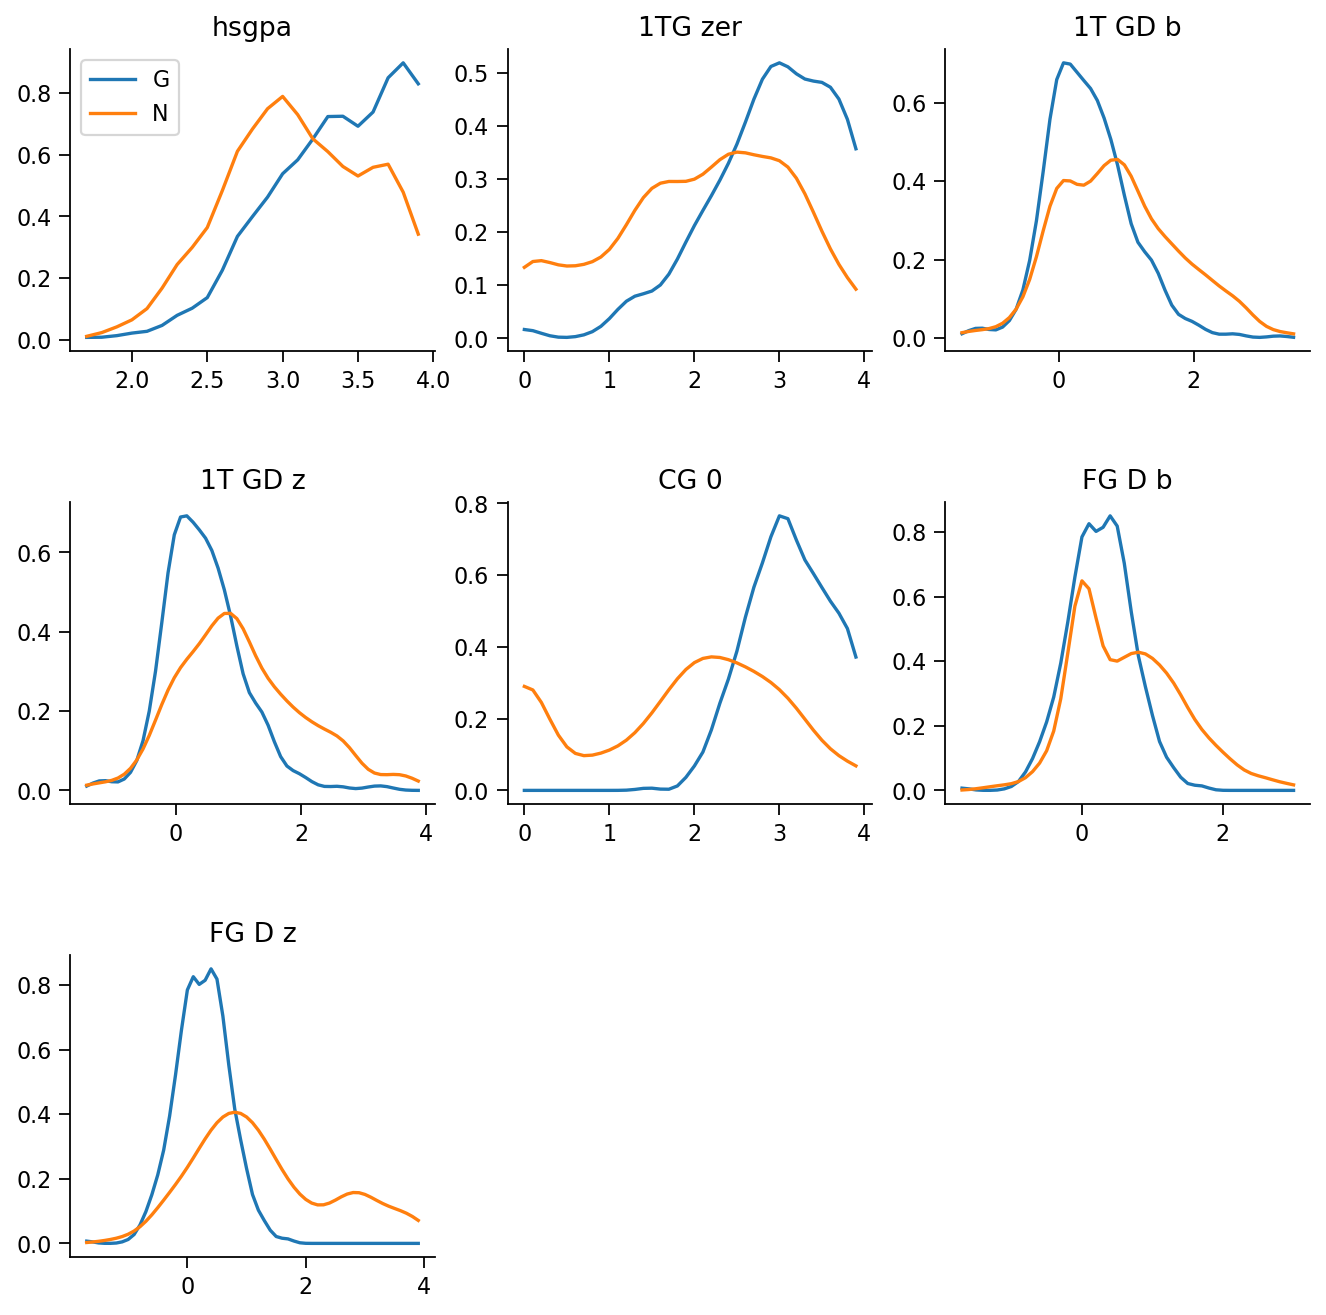

In [5]:
# note that null values in dataframe were filled with zeros which will shift probability density towards zero for features
# that were filled with mostly null values

kde_plot(data.loc[:, float_cols  + ['RATE']],
         outcome_col = 'RATE',
         n_col = 3,
         plot_legend = True,
         f_size = (10,10));

## Pipeline

Lets break down our pipeline into stages: in this case, we want to perform some feature selection (e.g. drop low variance features), data preprocessing (calculate polynomial features) before we fit an estimator (our learning algorithm).

We can consider seperate stages we want to perform for numerical and categorical features before we fit a model. Scikit Learn has a handy FeatureUnion class, which allows us to perform a stage of the pipeline in parrallel, and combine the results before we move on to the next step. 

Lets think what we want to do for the numerical and categorical features. We will later combine these using a feature union, as they should be performed in parrallel, not sequentially.

For numerical we want to:
- select numerical features from our input
- remove zero variance features, and optionally low variance features
- check for any correlations and remove if above a threshold
- scale the data (OptionalStandardScaler allows us to toggle this on or off)
- calculate polynomial features (interactions). This can be toggled as if degree = 1 it will just return original features

In [6]:
# data pipeline for numerical features
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(float_cols + int_cols)),
    ('zero_var', ZeroVariance(near_zero=True)),
    ('correlation', FindCorrelation(threshold=0.9)),
    ('opt_scaler', OptionalStandardScaler(scale=False)),
    ('poly_features', PolynomialFeatures(degree=1, include_bias=False)),
])

### Aside: recovering feature names

One difficulty I encountered was reconstructing labels once we have run data through the pipeline.
Numpy isn't really the best tool for holding metadata associated with the array- that is where Pandas shines.

Here is a little example of how to recover a dataframe with named columns after running the data through the pipeline.

In [7]:
#-----------------------------------------------------------
#
# example: run through num_pipeline.
# Get back an numpy array. 
# Note that all same datatype now: numpy can only consider
# homogenous data types, so integer converted to float.
#
#-----------------------------------------------------------

num_arr = num_pipeline.fit_transform(features_train)
# first 5 rows
print(num_arr[:5, :])

[[-5.000e-02 -5.000e-02  2.970e+00  4.800e-01  4.800e-01  5.400e+02
   1.120e+03  0.000e+00  0.000e+00  2.000e+00  7.000e+00  1.200e+01
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.170e+02]
 [ 6.290e-01  6.290e-01  3.394e+00  4.660e-01  4.660e-01  6.500e+02
   1.240e+03  4.000e+00  1.000e+00  1.000e+00  5.000e+00  1.600e+01
   2.410e+02  3.000e+00  0.000e+00  0.000e+00  1.000e+00  1.270e+02]
 [-5.330e-01 -5.330e-01  3.729e+00 -4.290e-01 -4.290e-01  5.000e+02
   9.500e+02  1.000e+00  0.000e+00  2.000e+00  7.000e+00  1.200e+01
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  4.800e+01]
 [ 6.900e-01  6.900e-01  2.188e+00  1.502e+00  1.502e+00  5.200e+02
   1.300e+03  2.000e+00  1.000e+00  2.000e+00  4.000e+00  1.600e+01
   2.410e+02  4.000e+00  1.000e+00  0.000e+00  1.000e+00  6.800e+01]
 [ 0.000e+00  2.800e+00  3.833e+00 -1.033e+00 -1.033e+00  6.000e+02
   1.100e+03  0.000e+00  0.000e+00  2.000e+00  7.000e+00  1.600e+01
   2.410e+02  0.000e+00  0.000e+00  0.000e+0

In [8]:
#-----------------------------------------------------------
#
# We can access steps in the fitted pipeline using get_params() method.
# We want to access the get_feature_names() method in each step, which 
# will allow us to filter an array of names at each step to correspond to 
# the features that are being selected
#
#-----------------------------------------------------------

# step 1: those filtered by low variance
names_1 = num_pipeline.get_params()['zero_var'].get_feature_names(np.array(float_cols + int_cols))
# step 2: those filtered by correlation. Pass in the remaining names from the previous step
names_2 = num_pipeline.get_params()['correlation'].get_feature_names(names_1)
# step3: those from interaction
names_3 = num_pipeline.get_params()['poly_features'].get_feature_names(names_2)

# and prove we have recovered names...
pd.DataFrame(num_arr, columns=names_3).head()

,1T GD b,1T GD z,CG 0,FG D b,FG D z,SUPER V,Superset,AL,FAR,SEX,ETHNIC,termhrs,CRS1,gradeN,Change,C F STEM,STEM1,CUMHRS2
0,-0.050,-0.050,2.970,0.480,0.480,540.0,1120.0,0.0,0.0,2.0,7.0,12.0,0.0,0.0,0.0,0.0,0.0,117.0
1,0.629,0.629,3.394,0.466,0.466,650.0,1240.0,4.0,1.0,1.0,5.0,16.0,241.0,3.0,0.0,0.0,1.0,127.0
2,-0.533,-0.533,3.729,-0.429,-0.429,500.0,950.0,1.0,0.0,2.0,7.0,12.0,0.0,0.0,0.0,0.0,0.0,48.0
3,0.690,0.690,2.188,1.502,1.502,520.0,1300.0,2.0,1.0,2.0,4.0,16.0,241.0,4.0,1.0,0.0,1.0,68.0
4,0.000,2.800,3.833,-1.033,-1.033,600.0,1100.0,0.0,0.0,2.0,7.0,16.0,241.0,0.0,0.0,0.0,1.0,18.0


### Putting together the pipeline

We will create a FeatureUnion of the numerical and categorical pipeline. This ensures they run in parallel- if they ran sequentially the results of one would be the input of the next, which we certainly dont want!

Following the feature union of the numerical and categorical pipeline, we perform a final correlation check, and a basic pipeline check via the PipelineChecker. At present this only ensures the train and test feature array have the same number of columns, but I will extend in future to check values as well (e.g. for outliers that will cause the model to be extrapolating, and may be producing unreliable results).

This pipeline can be used as a template, and we can append a final estimator (i.e. learning algorithm) to the end, allowing us to examine different models in isolation. I have seen people use a bunch of estimators in the same pipeline (so the model chooses the best by CV criteria), but I prefer to have more control and study the models in isolation.

In [9]:
#-----------------------------------------------------------
#
# Use feature union to make a big pipeline
#
#-----------------------------------------------------------

prep_pipe = Pipeline([
        
    ('union', FeatureUnion(
        transformer_list = [
                    
            # pipeline to transform numeric features
            ('num_pipeline', num_pipeline),
                    
        ],
                
        #other arguments for FeatureInion        
        n_jobs = 1,
        transformer_weights = None
    )),
        
    # final correlation check
    ('correlation', FindCorrelation(threshold=0.9)),
        
    # error checking
    ('checker', PipelineChecker()),
])


## Modelling

The main joy of pipelines is that we can treat the preprocessing steps as hyperparameters! Lets dig into a couple of examples to show why this is so useful

### Extra Trees

Here, we dont need to create non-linear terms as a tree based model can account for this. Further, it is uncommon to perform scaling for this model. We can turn parts of the pipeline 'off', and specify model specific hyperparemeters to tune.

We will investigate the following model specific parameters: number of estimators (trees), max tree depth and max features to sample at each split.

In [17]:
# use same preperation pipeline, just a different estimator
ext_est = copy.deepcopy(prep_pipe)
ext_est.steps.append(('extra_trees', ExtraTreesClassifier(random_state = 1234)))

In [18]:
# parameters
# We can set the params to a single value for those hyperparameters we want to fix,
# for example we want to turn off the scaler, dont drop any optional columns,
# and fix poly degree to 1 (i.e. no poly terms)
ext_param_grid = dict(union__num_pipeline__opt_scaler__scale=[False],
                  union__num_pipeline__poly_features__degree=[1],
                  extra_trees__n_estimators = [50, 100, 200],
                  extra_trees__max_depth = [x for x in range(1, 5)],
                  extra_trees__max_features = [2, 4, 6, 8])

In [19]:
grid_search_ext = GridSearchCV(estimator=ext_est,
                              param_grid=ext_param_grid,
                              scoring='roc_auc',
                              n_jobs=3,
                              cv=5,
                              refit=True,
                              verbose=1)

grid_search_ext.fit(features_train, outcome_train);

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    8.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   24.2s
[Parallel(n_jobs=3)]: Done 240 out of 240 | elapsed:   29.7s finished


In [20]:
print('Chosen params: {}\n\nTrain AUC score: {:0.3f}'.format(grid_search_ext.best_params_,
                                                        grid_search_ext.best_score_))

Chosen params: {'extra_trees__max_depth': 4, 'extra_trees__max_features': 6, 'extra_trees__n_estimators': 50, 'union__num_pipeline__opt_scaler__scale': False, 'union__num_pipeline__poly_features__degree': 1}

Train AUC score: 0.977


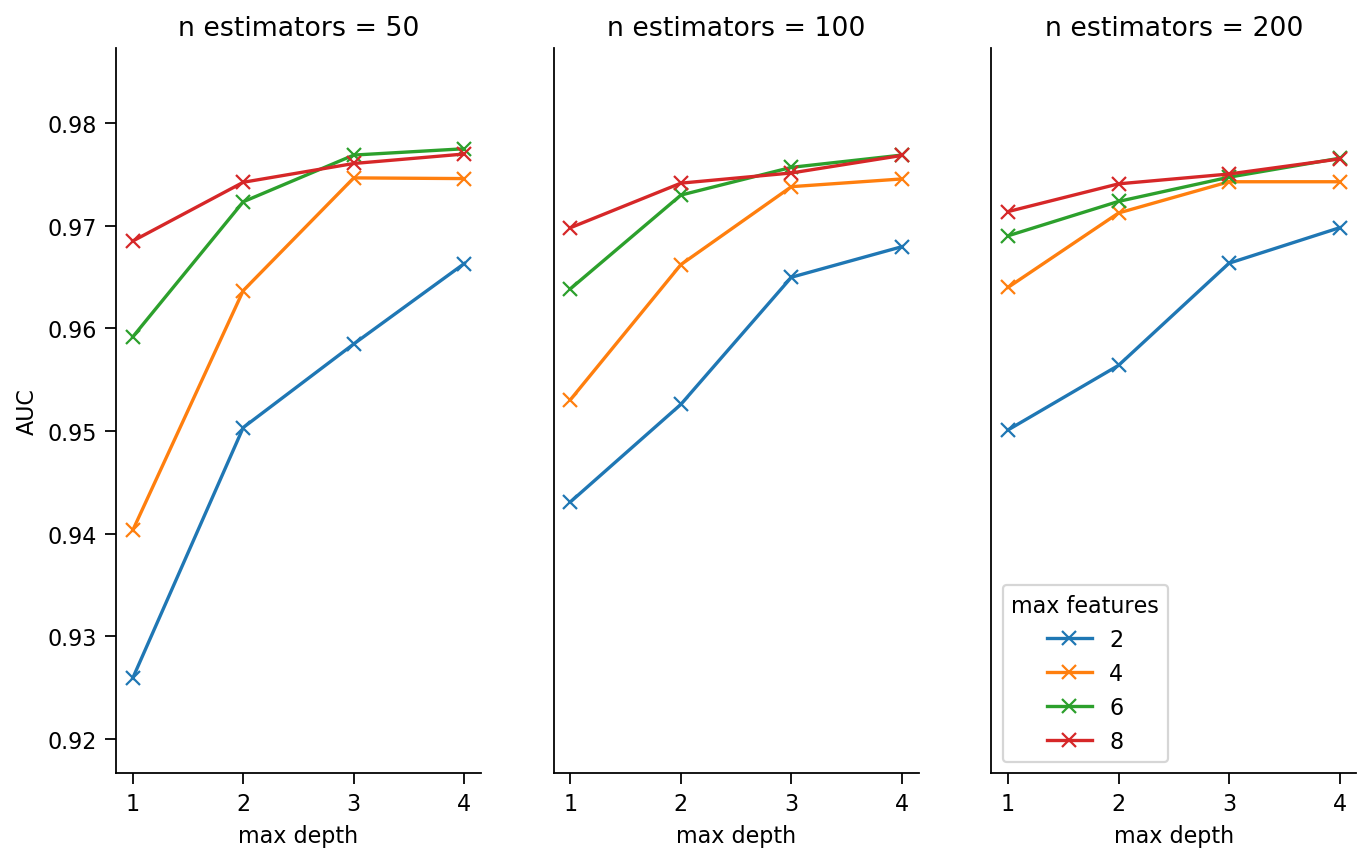

In [21]:
#-----------------------------------------------------------
#
# Visualise CV results
#
#-----------------------------------------------------------

ext_results = pd.DataFrame(grid_search_ext.cv_results_)

ext_results.dropna(inplace=True)

ext_plt_cols = ['param_extra_trees__n_estimators',
               'param_extra_trees__max_features',
               'param_extra_trees__max_depth',
               'mean_test_score',
               'std_test_score']

ext_ = ext_results.loc[:, ext_plt_cols]
ext_ = ext_.rename(columns = {'param_extra_trees__n_estimators':'n estimators',
                      'param_extra_trees__max_depth':'max depth',
                      'param_extra_trees__max_features':'max features',
                      'mean_test_score' : 'AUC'})
        
train_plot(ext_, f_size = (10,6));

### Once again, it may be useful to rebuild feature dataset with names to examine attributes of the model

The features will be different, as we made different choices in our data processing steps in the pipeline. Most notably, we didnt allow polynomial features to be generated.

In [22]:
# rebuild features. Notice we selected polynomial terms
# can access parts of the pipeline like so
num_pipe_ext = grid_search_ext.best_estimator_.get_params()['union__num_pipeline']

names_1a = num_pipe_ext.get_params()['zero_var'].get_feature_names(np.array(float_cols + int_cols))
names_2a = num_pipe_ext.get_params()['correlation'].get_feature_names(names_1a)
names_3a = num_pipe_ext.get_params()['poly_features'].get_feature_names(names_2a)

names_1c = np.array(names_3a)
ext_feature_names = grid_search_ext.best_estimator_.get_params()['correlation'].get_feature_names(names_1c)

In [23]:
# Lets look at feature importance - relates to how many times the
# feature was chosen for a split in the tree

ext_model = grid_search_ext.best_estimator_.get_params()['extra_trees']
ext_importance = ext_model.feature_importances_
sorted(list(zip( ext_importance, ext_feature_names )), key = lambda x: x[0], reverse=True)

[(0.6338338727699345, 'CUMHRS2'),
 (0.16508650788404655, 'FG D z'),
 (0.08212250133438763, 'gradeN'),
 (0.03549628367887771, 'FG D b'),
 (0.03502658155839638, '1T GD z'),
 (0.012029522981608112, 'Superset'),
 (0.007323847078878721, 'CRS1'),
 (0.006604255106996328, 'SUPER V'),
 (0.005762304302104005, 'STEM1'),
 (0.00510635756911718, 'C F STEM'),
 (0.004845761723934614, 'termhrs'),
 (0.0030046779060334482, 'ETHNIC'),
 (0.0016323837647789809, 'AL'),
 (0.0009457437458780662, 'SEX'),
 (0.0005967259522468673, 'FAR'),
 (0.0005826726427808853, 'Change')]

### AdaBoost

In [24]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import ExtraTreeClassifier

# use same preperation pipeline, just a different estimator
ada_est = copy.deepcopy(prep_pipe)
ada_est.steps.append(('adaboost', AdaBoostClassifier(ExtraTreeClassifier(random_state = 1234, max_depth=None))))

In [25]:
# parameters
# We can set the params to a single value for those hyperparameters we want to fix,
# for example we want to turn off the scaler, dont drop any optional columns,
# and fix poly degree to 1 (i.e. no poly terms)
ada_param_grid = dict(union__num_pipeline__opt_scaler__scale=[False],
                  union__num_pipeline__poly_features__degree=[1],
                  adaboost__base_estimator__min_samples_split = [x for x in range(0, 100, 10)],
                  adaboost__base_estimator__criterion = ["gini"],
                  adaboost__base_estimator__splitter = ["best", "random"],
                     adaboost__n_estimators=[50, 100],
                     adaboost__learning_rate=[0.25,0.5, 0.75, 1.0])

In [26]:
grid_search_ada = GridSearchCV(estimator=ada_est,
                              param_grid=ada_param_grid,
                              scoring='roc_auc',
                              n_jobs=3,
                              cv=10,
                              refit=True,
                              verbose=1)

grid_search_ada.fit(features_train, outcome_train);

Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   23.2s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   51.7s
[Parallel(n_jobs=3)]: Done 560 out of 560 | elapsed:  1.1min finished


In [27]:
print('Chosen params: {}\n\nTrain AUC score: {:0.3f}'.format(grid_search_ada.best_params_,
                                                        grid_search_ada.best_score_))

Chosen params: {'adaboost__base_estimator__criterion': 'gini', 'adaboost__base_estimator__min_samples_split': 16, 'adaboost__base_estimator__splitter': 'random', 'adaboost__learning_rate': 0.5, 'adaboost__n_estimators': 100, 'union__num_pipeline__opt_scaler__scale': False, 'union__num_pipeline__poly_features__degree': 1}

Train AUC score: 0.983


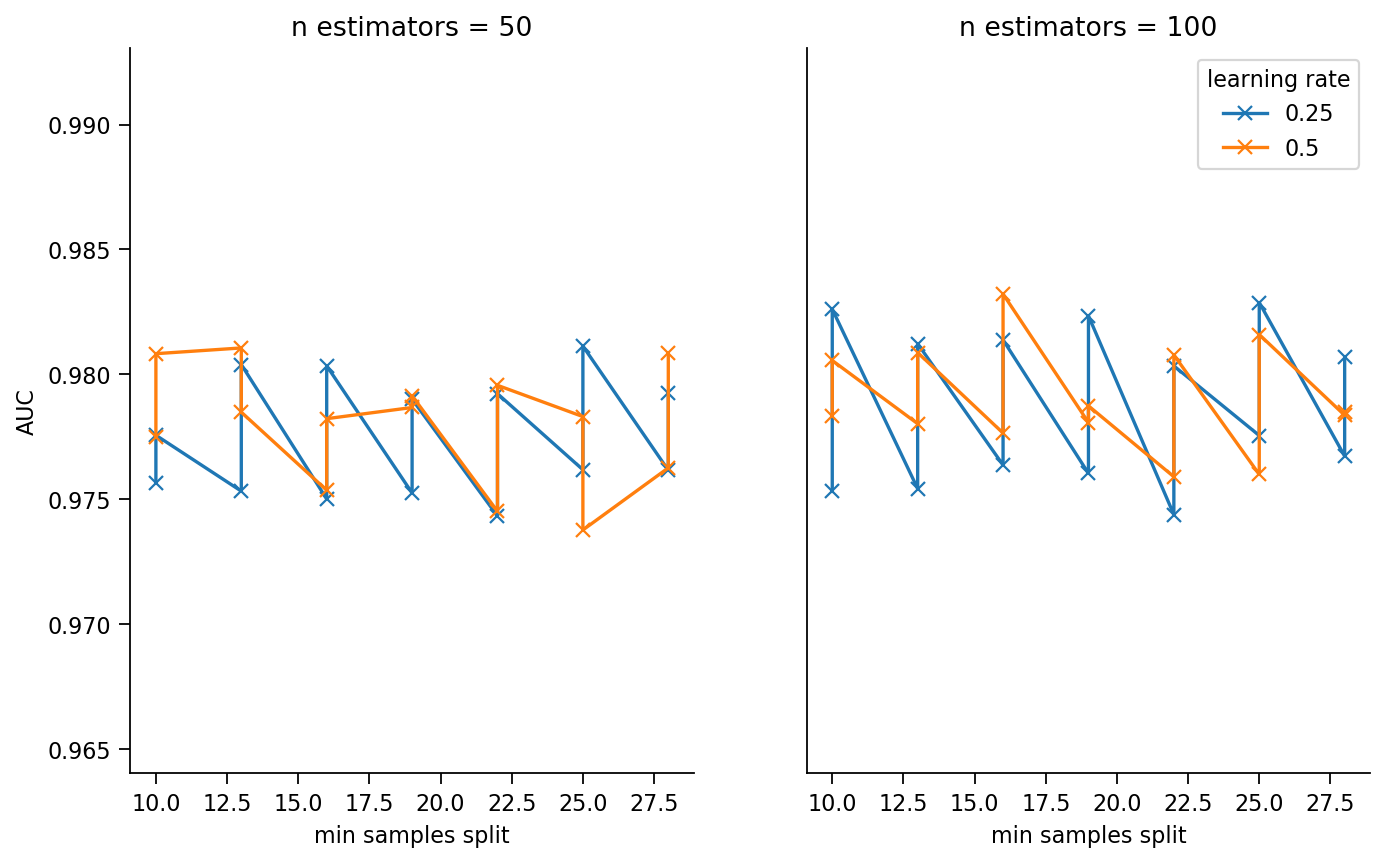

In [32]:
#-----------------------------------------------------------
#
# Visualise CV results
#
#-----------------------------------------------------------

ada_results = pd.DataFrame(grid_search_ada.cv_results_)

ada_results.dropna(inplace=True)

ada_plt_cols = ['param_adaboost__n_estimators',
               'param_adaboost__learning_rate',
               'param_adaboost__base_estimator__min_samples_split',
               'mean_test_score',
               'std_test_score']

ada_ = ada_results.loc[:, ada_plt_cols]
ada_ = ada_.rename(columns = {'param_adaboost__n_estimators':'n estimators',
                      'param_adaboost__learning_rate':'learning rate',
                      'param_adaboost__base_estimator__min_samples_split':'min samples split',
                      'mean_test_score' : 'AUC'})
        
train_plot(ada_, f_size = (10,6));

### Once again, it may be useful to rebuild feature dataset with names to examine attributes of the model

The features will be different, as we made different choices in our data processing steps in the pipeline. Most notably, we didnt allow polynomial features to be generated.

In [33]:
# rebuild features. Notice we selected polynomial terms
# can access parts of the pipeline like so
num_pipe_ext = grid_search_ext.best_estimator_.get_params()['union__num_pipeline']

names_1a = num_pipe_ext.get_params()['zero_var'].get_feature_names(np.array(float_cols + int_cols))
names_2a = num_pipe_ext.get_params()['correlation'].get_feature_names(names_1a)
names_3a = num_pipe_ext.get_params()['poly_features'].get_feature_names(names_2a)

names_1c = np.array(names_3a)
ext_feature_names = grid_search_ext.best_estimator_.get_params()['correlation'].get_feature_names(names_1c)

In [34]:
# Lets look at feature importance - relates to how many times the
# feature was chosen for a split in the tree

ext_model = grid_search_ext.best_estimator_.get_params()['extra_trees']
ext_importance = ext_model.feature_importances_
sorted(list(zip( ext_importance, ext_feature_names )), key = lambda x: x[0], reverse=True)

[(0.6338338727699345, 'CUMHRS2'),
 (0.16508650788404655, 'FG D z'),
 (0.08212250133438763, 'gradeN'),
 (0.03549628367887771, 'FG D b'),
 (0.03502658155839638, '1T GD z'),
 (0.012029522981608112, 'Superset'),
 (0.007323847078878721, 'CRS1'),
 (0.006604255106996328, 'SUPER V'),
 (0.005762304302104005, 'STEM1'),
 (0.00510635756911718, 'C F STEM'),
 (0.004845761723934614, 'termhrs'),
 (0.0030046779060334482, 'ETHNIC'),
 (0.0016323837647789809, 'AL'),
 (0.0009457437458780662, 'SEX'),
 (0.0005967259522468673, 'FAR'),
 (0.0005826726427808853, 'Change')]

# Model evaluation

Time for evaluation on the test set! The main purpose is to demonstrate that we can now feed the test data through the same pipeline using the predict() method. Remember, our pipeline object is wrapped up in a GridSearchCV object. This is really neat- it means we dont have to manually perform the same preprocessing steps on the test data set: the predict method will just apply the best model stored in the object.

We will look at a few perfomance metrics and graphics to interpret the final results as well.

In [35]:
# predictions: 'hard' (i.e. class, based on a 0.5 threshold)
# and probability, i.e. probability positive class
ext_predictions = grid_search_ext.predict(features_test)
ext_prob = grid_search_ext.predict_proba(features_test, )[:, 1]

ada_predictions = grid_search_ada.predict(features_test)
ada_prob = grid_search_ada.predict_proba(features_test)[:, 1]

We will consider the ROC curve initially, as we chose it as our metric for cross validation. I chose it as a 'safe' option: it is a useful metric as we get some degree of balance between sensitivity and specificity of the model. A 'perfect' model has an AUC of 1. 

We can plot the curves using the ROCPlot() class, and calculate the AUC with roc_auc_score():

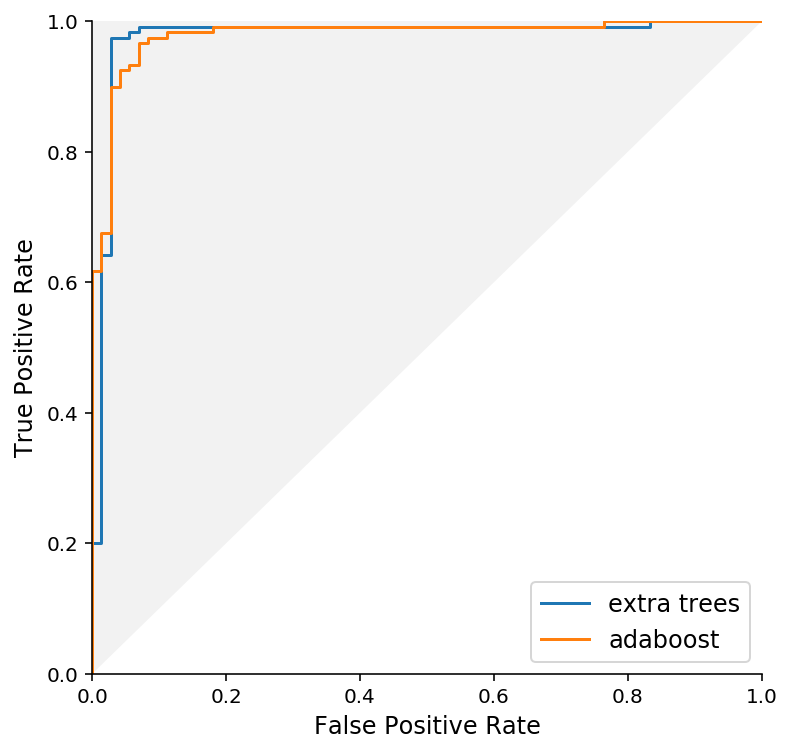

In [36]:
# intialise object
roc = ROCPlot(outcome_test.values) 
# add predictions from models
roc.calc_roc(ext_prob, 'extra trees')
roc.calc_roc(ada_prob, 'adaboost')

# use buit in helper method for plotting
roc.plot(figsize = (6,6));

In [37]:
print('''
Extra Trees AUC: {:0.3f}
Adaboost using Extra Tree Classifier AUC: {:0.3f}
'''.format(roc_auc_score(outcome_test, ext_prob),
          roc_auc_score(outcome_test, ada_prob))
     )


Extra Trees AUC: 0.977
Adaboost using Extra Tree Classifier AUC: 0.980



However, it is always useful to consider metrics that are applicable for the model use case. Presumably we would want to reach customers who are at risk of churn. Perhaps give them an offer (at our expense) to stop them churning.

Therefore, to maximise ROI for a campaign like this, we want to only send offers to customers who will truely churn: False positives would not have churned, and we may have sent them an offer for no reason.

A lift chart is a nice approach when considering how you might proactially use the model. We order the preddicted probabilities from highest to lowest, and we consider the percentage of positive events (churns) we find as a function of how many samples we test.

A business decision could be made to reach, say, 75% of customers who will churn. We can then read off our lift chart to see how much of the population we would have to contact to achieve this.

We see that using our logistic regression model, to catch 75% of churners, we have to test about 20% of our customer base. However, for the random forest model, we would only have to test about 10%, which could give us significant savings! We also see that we can get no false positives for up to about 70% of churning customers if we use the random forest model.


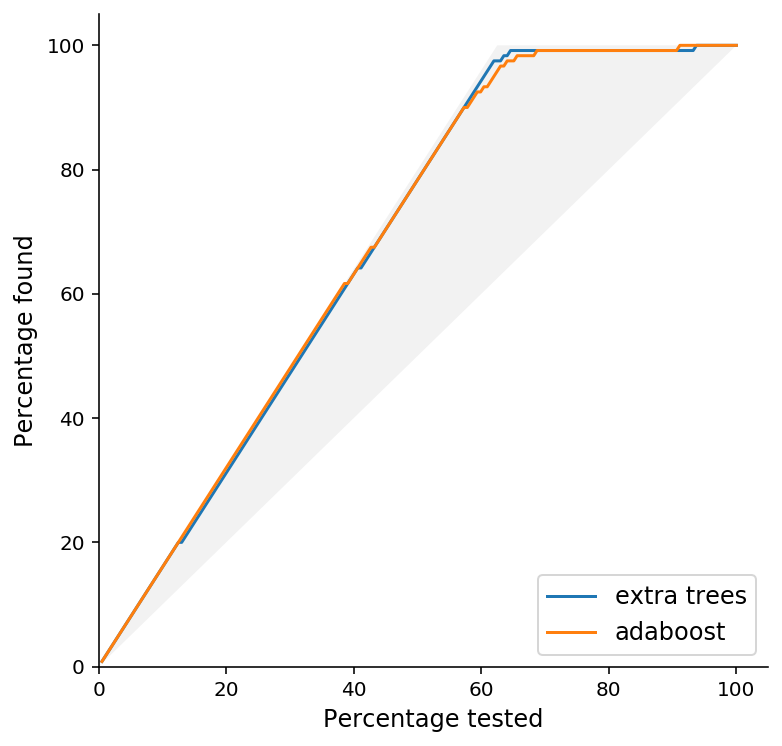

In [38]:
# initialise object
lift = LiftChart(outcome_test.values) 
# add the predictions
lift.calc_uplift(ext_prob, 'extra trees')
lift.calc_uplift(ada_prob, 'adaboost')


# built in helper method for plotting
lift.plot(thresh_pct=None, figsize = (6,6));

# Summary

Overall, we have demonstrated how to use sklearn pipelines to process data and fit learning algorithms, selecting the best combination of preprocessing and model parameters. We focussed on the Pipeline, FeatureUnion and GridSearchCV classes. We have also investigated some techniques for evaluating the results of our churn model.